## Using Keras to Build and Train Neural Networks

In this exercise we will use a neural network to predict diabetes using the Pima Diabetes Dataset.  We will start by training a Random Forest to get a performance baseline.  Then we will use the Keras package to quickly build and train a neural network and compare the performance.  We will see how different network structures affect the performance, training time, and level of overfitting (or underfitting).

## Pima Diabetes Dataset

* Kaggle Dataset (https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv)


### Attributes: (all numeric-valued)
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)
   9. Class variable (0 or 1)

The UCI Pima Diabetes Dataset which has 8 numerical predictors and a binary outcome.

In [1]:
#Preliminaries

from __future__ import absolute_import, division, print_function  # Python 2/3 compatibility

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.ensemble import RandomForestClassifier

import seaborn as sns

%matplotlib inline

In [2]:
## Import Keras objects for Deep Learning

from tensorflow.keras.models  import Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, RMSprop

In [3]:
## Load in the data set (Internet Access needed)
# Download pima-indians-diabetes.csv from https://www.kaggle.com/datasets/kumargh/pimaindiansdiabetescsv

seed_value = 11111
url = "pima-indians-diabetes.csv"
names = ["times_pregnant", "glucose_tolerance_test", "blood_pressure", "skin_thickness", "insulin", 
         "bmi", "pedigree_function", "age", "has_diabetes"]
diabetes_df = pd.read_csv(url, names=names)

In [4]:
# Take a peek at the data -- if there are lots of "NaN" you may have internet connectivity issues
print(diabetes_df.shape)
diabetes_df.sample(5)

(768, 9)


,times_pregnant,glucose_tolerance_test,blood_pressure,skin_thickness,insulin,bmi,pedigree_function,age,has_diabetes
8,2,197,70,45,543,30.5,0.158,53,1
681,0,162,76,36,0,49.6,0.364,26,1
724,1,111,94,0,0,32.8,0.265,45,0
213,0,140,65,26,130,42.6,0.431,24,1
593,2,82,52,22,115,28.5,1.699,25,0


In [5]:
X = diabetes_df.iloc[:, :-1].values
y = diabetes_df["has_diabetes"].values

In [6]:
# Split the data to Train, and Test (75%, 25%)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed_value, stratify=y)

In [7]:
np.mean(y), np.mean(1-y)

(0.3489583333333333, 0.6510416666666666)

Above, we see that about 35% of the patients in this dataset have diabetes, while 65% do not.  This means we can get an accuracy of 65% without any model - just declare that no one has diabetes. We will calculate the ROC-AUC score to evaluate performance of our model, and also look at the accuracy as well to see if we improved upon the 65% accuracy.
## Exercise: Get a baseline performance using Random Forest
To begin, and get a baseline for classifier performance:
1. Train a Random Forest model with 200 trees on the training data.
2. Calculate the accuracy and roc_auc_score of the predictions.

In [8]:
## Train the RF Model
rf_model = RandomForestClassifier(n_estimators=200, random_state=seed_value)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=200, random_state=11111)

In [9]:
# Make predictions on the test set - both "hard" predictions, and the scores (percent of trees voting yes)
y_pred_class_rf = rf_model.predict(X_test)
y_pred_prob_rf = rf_model.predict_proba(X_test)

print('accuracy is {:.3f}, roc-auc is {:.3f}'.format(
    accuracy_score(y_test, y_pred_class_rf), roc_auc_score(y_test, y_pred_prob_rf[:,1])))

accuracy is 0.771, roc-auc is 0.795


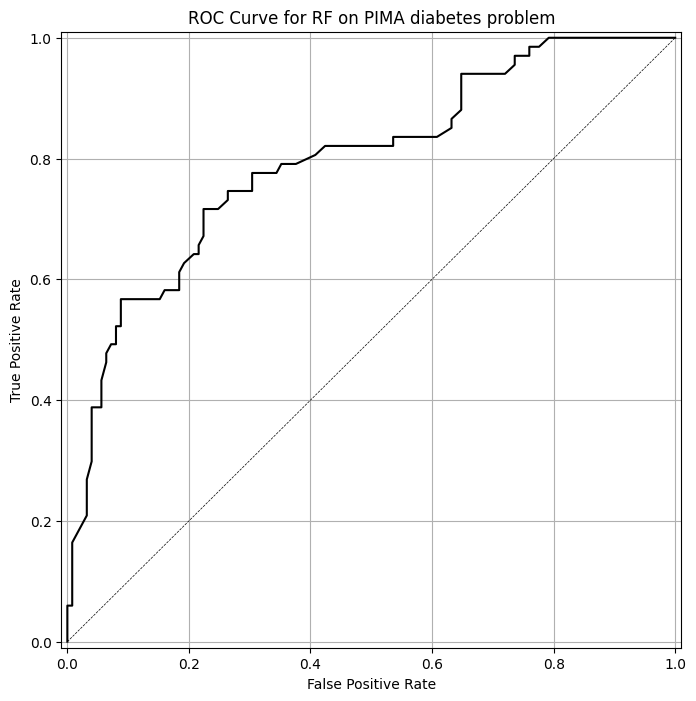

In [10]:
def plot_roc(y_test, y_pred, model_name):
    fpr, tpr, thr = roc_curve(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.plot(fpr, tpr, 'k-')
    ax.plot([0, 1], [0, 1], 'k--', linewidth=.5)  # roc curve for random model
    ax.grid(True)
    ax.set(title='ROC Curve for {} on PIMA diabetes problem'.format(model_name),
           xlim=[-0.01, 1.01], ylim=[-0.01, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

plot_roc(y_test, y_pred_prob_rf[:, 1], 'RF')

## Build a Single Hidden Layer Neural Network

We will use the Sequential model to quickly build a neural network.  Our first network will be a single layer network.  We have 8 variables, so we set the input shape to 8.  Let's start by having a single hidden layer with 8 nodes.

In [11]:
## First let's normalize the data
## This aids the training of neural nets by providing numerical stability
## Random Forest does not need this as it finds a split only, as opposed to performing matrix multiplications

normalizer = StandardScaler()
X_train_norm = normalizer.fit_transform(X_train)
X_test_norm = normalizer.transform(X_test)

In [12]:
# Define the Model 
# Input size is 8-dimensional
# 1 hidden layer, 8 hidden nodes, sigmoid activation
# Final layer has just one node with a sigmoid activation (standard for binary classification)

import os, random, numpy as np
import tensorflow as tf 

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

model_1 = Sequential([
    Dense(8, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [13]:
#  This is a nice tool to view the model you have created and count the parameters

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 72        
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


### Comprehension question:
Why do we have 81 parameters?  Does that make sense?


Let's fit our model for 100 epochs.

In [14]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_1.compile(optimizer=SGD(learning_rate=0.003), loss="binary_crossentropy", metrics=["accuracy"])

run_hist_1 = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=100, batch_size=32)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/100
18/18 [==============================] - 1s 15ms/step - loss: 0.7638 - accuracy: 0.4583 - val_loss: 0.7457 - val_accuracy: 0.4479
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 0.7578 - accuracy: 0.4705 - val_loss: 0.7402 - val_accuracy: 0.4583
Epoch 3/100
18/18 [==============================] - 0s 5ms/step - loss: 0.7521 - accuracy: 0.4792 - val_loss: 0.7349 - val_accuracy: 0.4792
Epoch 4/100
18/18 [==============================] - 0s 5ms/step - loss: 0.7466 - accuracy: 0.4948 - val_loss: 0.7299 - val_accuracy: 0.4896
Epoch 5/100
18/18 [==============================] - 0s 5ms/step - loss: 0.7412 - accuracy: 0.5017 - val_loss: 0.7251 - val_accuracy: 0.4948
Epoch 6/100
18/18 [==============================] - 0s 5ms/step - loss: 0.7361 - accuracy: 0.5226 - val_loss: 0.7204 - val_accuracy: 0.5156
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 0.7311 - accuracy: 0.5295 - val_loss: 0.7160 - val_accuracy: 0.5312
Epoch 8/100


In [15]:
## Like we did for the Random Forest, we generate two kinds of predictions
#  One is a hard decision, the other is a probabilitistic score.

y_pred_prob_nn_1 = model_1.predict(X_test_norm)
y_pred_class_nn_1 = (y_pred_prob_nn_1 >= 0.5).astype('int32')

6/6 [==============================] - 0s 2ms/step


In [16]:
# Let's check out the outputs to get a feel for how keras apis work.
y_pred_class_nn_1[:10]

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1]])

In [17]:
y_pred_prob_nn_1[:10]

array([[0.498032  ],
       [0.47510898],
       [0.5763236 ],
       [0.31110892],
       [0.3703766 ],
       [0.61320966],
       [0.42372942],
       [0.25438112],
       [0.20729397],
       [0.848382  ]], dtype=float32)

accuracy is 0.719, roc-auc is 0.745


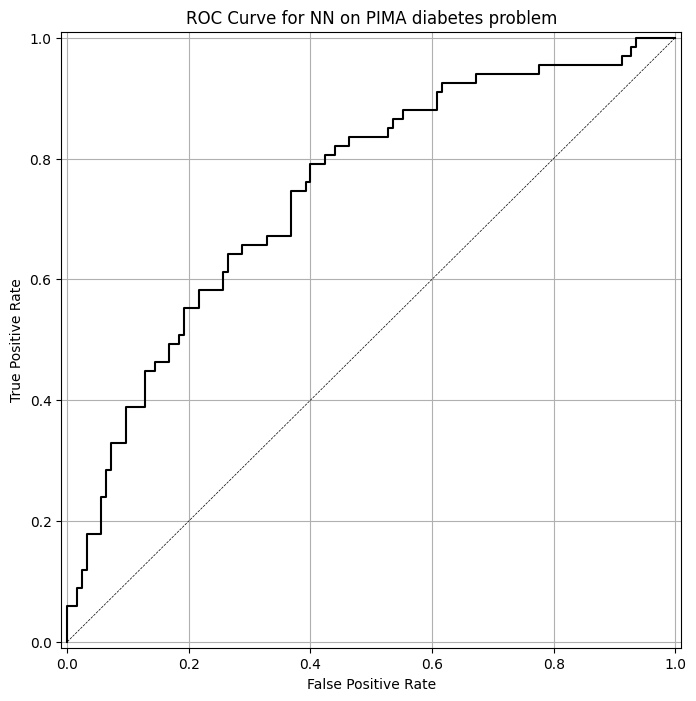

In [18]:
# Print model performance and plot the roc curve
print('accuracy is {:.3f}, roc-auc is {:.3f}'.format(
    accuracy_score(y_test, y_pred_class_nn_1), roc_auc_score(y_test, y_pred_prob_nn_1)))

plot_roc(y_test, y_pred_prob_nn_1, 'NN')

There may be some variation in exact numbers due to randomness, but you should get results in the same ballpark as the Random Forest - between 75% and 85% accuracy, between .8 and .9 for AUC.

Let's look at the `run_hist_1` object that was created, specifically its `history` attribute.

In [19]:
run_hist_1.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Let's plot the training loss and the validation loss over the different epochs and see how it looks.

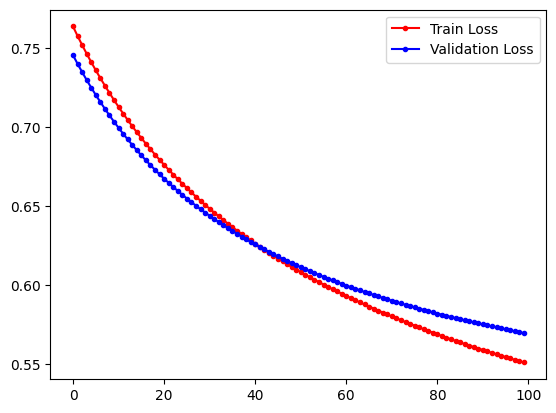

In [20]:
fig, ax = plt.subplots()
ax.plot(run_hist_1.history["loss"],'r', marker='.', label="Train Loss")
ax.plot(run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss")
ax.legend()

Looks like the losses are still going down on both the training set and the validation set.  This suggests that the model might benefit from further training.  Let's train the model a little more and see what happens. Note that it will pick up from where it left off. Train for 400 more epochs.

In [21]:
## Note that when we call "fit" again, it picks up where it left off
run_hist_1b = model_1.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=400, batch_size=32)

Epoch 1/400
18/18 [==============================] - 0s 11ms/step - loss: 0.5500 - accuracy: 0.7222 - val_loss: 0.5689 - val_accuracy: 0.7135
Epoch 2/400
18/18 [==============================] - 0s 7ms/step - loss: 0.5492 - accuracy: 0.7240 - val_loss: 0.5683 - val_accuracy: 0.7188
Epoch 3/400
18/18 [==============================] - 0s 7ms/step - loss: 0.5484 - accuracy: 0.7240 - val_loss: 0.5678 - val_accuracy: 0.7188
Epoch 4/400
18/18 [==============================] - 0s 7ms/step - loss: 0.5476 - accuracy: 0.7222 - val_loss: 0.5672 - val_accuracy: 0.7135
Epoch 5/400
18/18 [==============================] - 0s 8ms/step - loss: 0.5467 - accuracy: 0.7257 - val_loss: 0.5667 - val_accuracy: 0.7135
Epoch 6/400
18/18 [==============================] - 0s 6ms/step - loss: 0.5459 - accuracy: 0.7240 - val_loss: 0.5661 - val_accuracy: 0.7135
Epoch 7/400
18/18 [==============================] - 0s 9ms/step - loss: 0.5451 - accuracy: 0.7240 - val_loss: 0.5656 - val_accuracy: 0.7135
Epoch 8/400


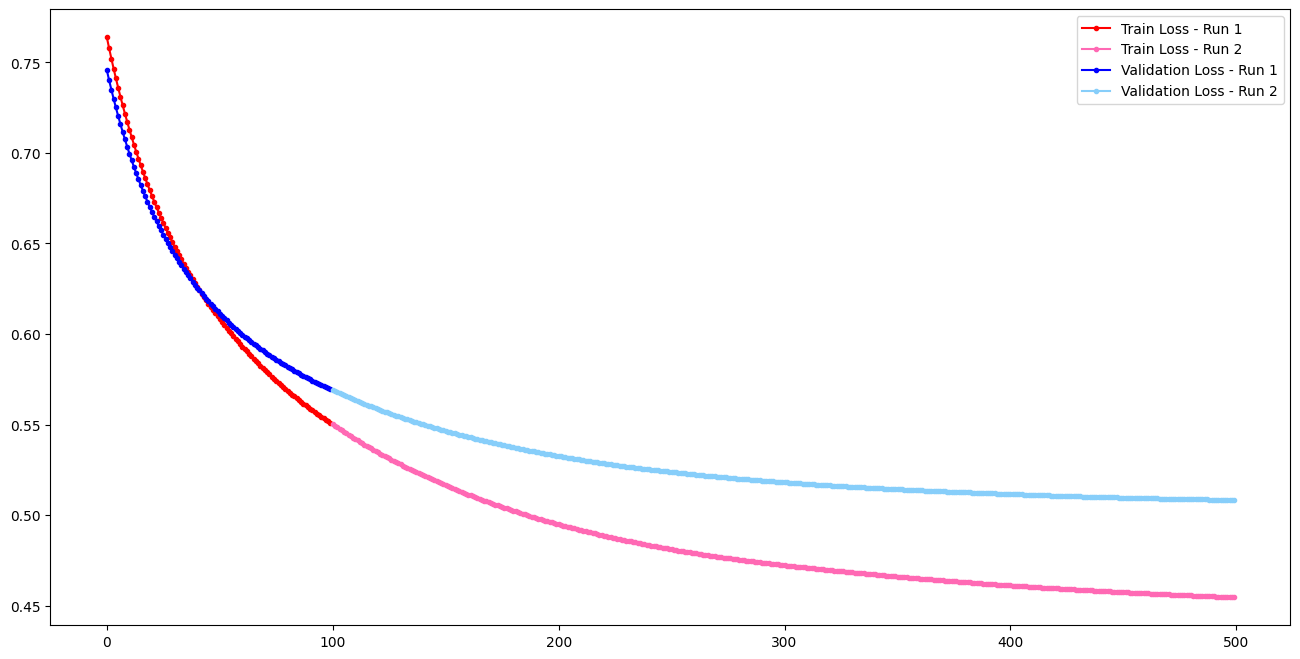

In [22]:
n = len(run_hist_1.history["loss"])
m = len(run_hist_1b.history['loss'])
fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(range(n), run_hist_1.history["loss"],'r', marker='.', label="Train Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["loss"], 'hotpink', marker='.', label="Train Loss - Run 2")

ax.plot(range(n), run_hist_1.history["val_loss"],'b', marker='.', label="Validation Loss - Run 1")
ax.plot(range(n, n+m), run_hist_1b.history["val_loss"], 'LightSkyBlue', marker='.',  label="Validation Loss - Run 2")

ax.legend()

Note that this graph begins where the other left off.  While the training loss is still going down, it looks like the validation loss has stabilized (or even gotten worse!).  This suggests that our network will not benefit from further training.  What is the appropriate number of epochs?

# <span style="color:blue">แบบฝึกปฏิบัติ</span>

(รวม 100 คะแนน) ให้นิสิตใช้พื้นที่ต่อไปนี้ ในการเพิ่มโค้ดให้เป็นไปตามข้อกำหนดต่อไปนี้
1. (50 คะแนน) เพิ่มเซลโค้ด เพื่อ
   * สร้างโมเดลที่มีเลเยอร์ hidden 2 ชั้น แต่ละชั้นมี 6 โหนด
   * ปรับโค้ดให้สามารถรับอินพุตที่มีจำนวน feature ตามข้อมูลเทรนที่จะถูกส่งเข้ามา (ปราศจากการใช้ค่าคงที่ 8 ที่ถูกระบุอยู่ในโค้ด ณ ตอนนี้)
   * สำหรับเลเยอร์ hidden ให้ใช้ activation function เป็น "relu" และเลเยอร์ output เป็น "sigmoid"
   * ใช้ learning rate เท่ากับ 0.003 และเทรนด้วยจำนวน 1500 epochs ส่วนสำหรับ Hyperparameter ที่เหลือให้ใช้ค่าคงเดิม
   * วาดกราฟของค่า loss และ accuracy ด้วยทั้งชุดข้อมูล train และ test (ดังตัวอย่างในรูปนี้)
  <img src="https://drive.google.com/uc?id=1GuN0KQf64rGMa4oCY2upnbOTMzWaXmbT" style="height:360px">
2. (50 คะแนน) เพิ่มอีกเซลโค้ด เพื่อสร้างโมเดลที่มีการปรับโครงสร้างที่เหมาะสมขึ้น รวมถึงการปรับค่า Hyperparameter ต่าง ๆ เพื่อให้โมเดลใหม่ได้ผลลัพธ์ที่ดีขึ้น (โดยพิจารณาจากค่า accuracy) และในการเทรนโมเดลใหม่นี้ ห้ามมีการใช้ Early Stopping 
   * ให้วาดกราฟของค่า loss และ accuracy ของโมเดลใหม่นี้ด้วย
   * อธิบายให้เห็นว่าผลลัพธ์ที่ได้จากโมเดลใหม่นั้นดีขึ้นจากโมเดลเดิม

In [27]:
model_2 = Sequential([
    Dense(6, input_shape=(8,), activation="relu"),
    Dense(6, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [28]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6)                 54        
                                                                 
 dense_6 (Dense)             (None, 6)                 42        
                                                                 
 dense_7 (Dense)             (None, 1)                 7         
                                                                 
Total params: 103
Trainable params: 103
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_2.compile(optimizer=SGD(learning_rate=0.003), loss="binary_crossentropy", metrics=["accuracy"])

run_hist_2 = model_2.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=1500, batch_size=32)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/1500
18/18 [==============================] - 1s 20ms/step - loss: 0.7464 - accuracy: 0.6528 - val_loss: 0.7318 - val_accuracy: 0.6458
Epoch 2/1500
18/18 [==============================] - 0s 10ms/step - loss: 0.7391 - accuracy: 0.6528 - val_loss: 0.7263 - val_accuracy: 0.6510
Epoch 3/1500
18/18 [==============================] - 0s 12ms/step - loss: 0.7323 - accuracy: 0.6493 - val_loss: 0.7212 - val_accuracy: 0.6510
Epoch 4/1500
18/18 [==============================] - 0s 10ms/step - loss: 0.7258 - accuracy: 0.6510 - val_loss: 0.7164 - val_accuracy: 0.6510
Epoch 5/1500
18/18 [==============================] - 0s 7ms/step - loss: 0.7198 - accuracy: 0.6510 - val_loss: 0.7120 - val_accuracy: 0.6510
Epoch 6/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.7142 - accuracy: 0.6510 - val_loss: 0.7077 - val_accuracy: 0.6510
Epoch 7/1500
18/18 [==============================] - 0s 6ms/step - loss: 0.7090 - accuracy: 0.6510 - val_loss: 0.7038 - val_accuracy: 0.6510
Ep

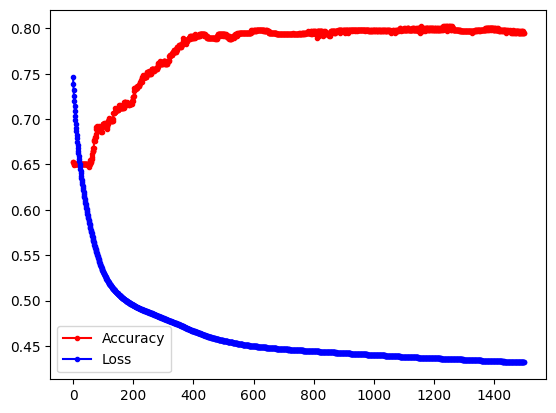

In [32]:
fig, ax = plt.subplots()
ax.plot(run_hist_2.history["accuracy"],'r', marker='.', label="Accuracy")
ax.plot(run_hist_2.history["loss"],'b', marker='.', label="Loss")
ax.legend()

In [57]:
model_3 = Sequential([
    Dense(5, input_shape=(8,), activation="relu"),
    Dense(5, input_shape=(8,), activation="relu"),
    Dense(5, input_shape=(8,), activation="relu"),
    Dense(1, activation="sigmoid")
])

In [58]:
model_3.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_32 (Dense)            (None, 5)                 45        
                                                                 
 dense_33 (Dense)            (None, 5)                 30        
                                                                 
 dense_34 (Dense)            (None, 5)                 30        
                                                                 
 dense_35 (Dense)            (None, 1)                 6         
                                                                 
Total params: 111
Trainable params: 111
Non-trainable params: 0
_________________________________________________________________


In [59]:
# Fit(Train) the Model

# Compile the model with Optimizer, Loss Function and Metrics
# Roc-Auc is not available in Keras as an off the shelf metric yet, so we will skip it here.

model_3.compile(optimizer=SGD(learning_rate=0.005), loss="binary_crossentropy", metrics=["accuracy"])

run_hist_3 = model_3.fit(X_train_norm, y_train, validation_data=(X_test_norm, y_test), epochs=500, batch_size=10)
# the fit function returns the run history. 
# It is very convenient, as it contains information about the model fit, iterations etc.

Epoch 1/500
58/58 [==============================] - 1s 14ms/step - loss: 0.7121 - accuracy: 0.3872 - val_loss: 0.7023 - val_accuracy: 0.4375
Epoch 2/500
58/58 [==============================] - 1s 10ms/step - loss: 0.6892 - accuracy: 0.5139 - val_loss: 0.6842 - val_accuracy: 0.5833
Epoch 3/500
58/58 [==============================] - 1s 10ms/step - loss: 0.6731 - accuracy: 0.6979 - val_loss: 0.6705 - val_accuracy: 0.7240
Epoch 4/500
58/58 [==============================] - 1s 13ms/step - loss: 0.6609 - accuracy: 0.7413 - val_loss: 0.6603 - val_accuracy: 0.7292
Epoch 5/500
58/58 [==============================] - 1s 9ms/step - loss: 0.6515 - accuracy: 0.7448 - val_loss: 0.6518 - val_accuracy: 0.7240
Epoch 6/500
58/58 [==============================] - 1s 13ms/step - loss: 0.6437 - accuracy: 0.7344 - val_loss: 0.6447 - val_accuracy: 0.7135
Epoch 7/500
58/58 [==============================] - 1s 13ms/step - loss: 0.6370 - accuracy: 0.7222 - val_loss: 0.6385 - val_accuracy: 0.7188
Epoch 8

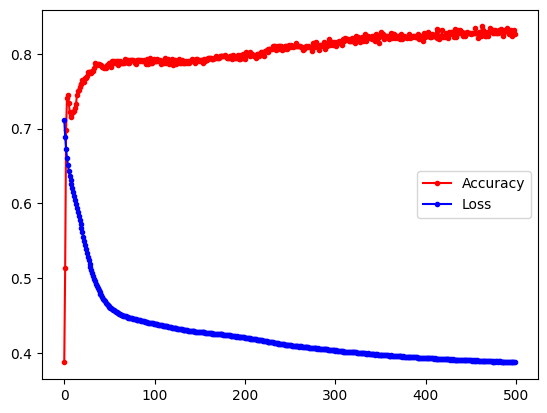

In [60]:
fig, ax = plt.subplots()
ax.plot(run_hist_3.history["accuracy"],'r', marker='.', label="Accuracy")
ax.plot(run_hist_3.history["loss"],'b', marker='.', label="Loss")
ax.legend()